In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime, timedelta
import xarray as xr
import urllib.request
from tqdm import tqdm
from shapely.geometry import mapping
import rasterio

In [2]:
ee.Initialize()

In [3]:
# Define dates of interest

In [4]:
N = 4 # N° de horas hacia atras de la animación
UTC = 3 # Pasaje entre UTC-0 y UTC-3

# Definir el lapso de la animación
DS_UTC_3 = datetime.now() - timedelta(hours=N)
DE_UTC_3 = datetime.now()

# Convertir a UTC 0 y al formato de entrada de GEE
DS_UTC_0 = (DS_UTC_3 + timedelta(hours=UTC)).strftime('%Y-%m-%dT%H:%M')
DE_UTC_0 = (DE_UTC_3 + timedelta(hours=UTC)).strftime('%Y-%m-%dT%H:%M')

print(DS_UTC_0, DE_UTC_0)

2024-09-10T11:59 2024-09-10T17:59


In [5]:
# Read ROI & Grid shapefiles

In [6]:
GDF_ROI = gpd.read_file(r"GIS/ROI.shp")

GDF_ROI

id                                           geometry
0 NaN  POLYGON ((-78.63690 -58.06573, -78.63690 -20.1...

In [7]:
BB_01 = GDF_ROI.total_bounds

# Define coordinates
x_min, y_min, x_max, y_max = BB_01

# Create ee.Geometry
ROI = ee.Geometry.Rectangle([x_min, y_min, x_max, y_max])

ROI

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -78.636899829875,
              -20.109963661379695
            ],
            [
              -78.636899829875,
              -58.06572985226802
            ],
            [
              -51.64464617108721,
              -58.06572985226802
            ],
            [
              -51.64464617108721,
              -20.109963661379695
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [8]:
# Este shape se utiliza por cuestiones de límite de memoria para descargar las imagenes localmente

GDF_GRD = gpd.read_file(r"GIS/Grid.shp")

GDF_GRD

FID                                           geometry
0    0  POLYGON ((-78.63690 -41.81696, -78.63690 -20.1...
1    1  POLYGON ((-65.14077 -41.81696, -65.14077 -20.1...
2    2  POLYGON ((-78.63690 -58.06573, -78.63690 -41.8...
3    3  POLYGON ((-65.14077 -58.06573, -65.14077 -41.8...

In [9]:
C_01 = ee.ImageCollection("NOAA/GOES/16/MCMIPF")\
        .filterBounds(ROI)\
        .filterDate(DS_UTC_0, DE_UTC_0)

C_01

In [10]:
# Get image collection size
S_01 = C_01.size().getInfo()

S_01

34

In [11]:
# Print de la ultima fecha disponible

# Última imagen disponible
UI = ee.Image(C_01.toList(S_01).get(S_01-1)) 

# Datetime de la última imágen disponible
UI_DT = (datetime.utcfromtimestamp(UI.getInfo()["properties"]["system:time_start"]/ 1000) - timedelta(hours=3)).strftime("%Y-%m-%d %H:%M")

# Calcular la latencia en minutos
LT = (datetime.now() - (datetime.utcfromtimestamp(UI.getInfo()["properties"]["system:time_start"]/ 1000) - timedelta(hours=3))).total_seconds()/60

print(f"{UI_DT} - Latencia de: {LT:.1f} minutos")

2024-09-10 14:30 - Latencia de: 29.0 minutos


In [12]:
# Create an empty ImageCollection to store the filtered images
C_02 = ee.ImageCollection([])

# Loop over the images starting from the last one, and keep 1 every 3 images

for i in range(S_01 - 1, -1, -3):  # Start at the last index, move backwards by 3

    # Get the image at the current index
    image = ee.Image(C_01.toList(S_01).get(i))

    # Merge the image with the collection
    C_02 = C_02.merge(ee.ImageCollection([image]))

# Reverse the order of the collection
C_02 = C_02.sort('system:time_start')

C_02


In [13]:
# Get image collection size
S_02 = C_02.size().getInfo()

S_02

12

In [14]:
# # Get spatial resolution
# OS = C_02.select("CMI_C01").first().projection().nominalScale().getInfo()

# print(f"Original scale: {OS:.1f} m")

In [15]:
# Definir función que escala las imágenes

# CMI_C01: BLUE
# CMI_C02: RED
# CMI_C03: IR

def scale_red_blue_nir(image):
    
    sc_blue = ee.Number(image.get("CMI_C01_scale"))
    off_blue = ee.Number(image.get("CMI_C01_offset"))
    
    sc_red = ee.Number(image.get("CMI_C02_scale"))
    off_red = ee.Number(image.get("CMI_C02_offset"))
    
    sc_nir = ee.Number(image.get("CMI_C03_scale"))
    off_nir = ee.Number(image.get("CMI_C03_offset"))
    
    blue_sc_off = image.select("CMI_C01").multiply(sc_blue).add(off_blue).rename("bl_scaled_off")
    red_sc_off = image.select("CMI_C02").multiply(sc_red).add(off_red).rename("red_scaled_off")
    nir_sc_off = image.select("CMI_C03").multiply(sc_nir).add(off_nir).rename("nir_scaled_off")
    
    # Add the scaled bands back to the image
    return image.addBands([blue_sc_off, red_sc_off, nir_sc_off])

In [16]:
# Map the function over the IC

C_02 = C_02.map(scale_red_blue_nir)

C_02

In [17]:
# Define function to calculate the synthetic green band

def synthetic_green(image):
    
    green_1 = image.select("red_scaled_off").multiply(0.45)

    green_2 = image.select("nir_scaled_off").multiply(0.10)

    green_3 = image.select("bl_scaled_off").multiply(0.45)

    green = green_1.add(green_2).add(green_3).rename("GREEN")
    
    return image.addBands(green)

In [18]:
# Map the function over the IC

C_02 = C_02.map(synthetic_green)

C_02

In [19]:
# C_02.first().bandNames().getInfo()

In [20]:
# Download images locally

for i in range(S_02):

    I = ee.Image(C_02.toList(S_02).get(i))

    D = (datetime.utcfromtimestamp(I.getInfo()["properties"]["system:time_start"]/ 1000) - timedelta(hours=3)).strftime("%Y-%m-%d %H:%M")

    for (E, G) in enumerate(range(len(GDF_GRD))):

        GRD = ee.Geometry(mapping(GDF_GRD["geometry"][G]))

        FN = f"{E+1:02d}.G-{i+1:03d}.tif"

        # Define the export parameters.
        url = I.getDownloadURL({
        "scale" : 5000,
        "bands" : ["red_scaled_off", "GREEN", "bl_scaled_off"],
        "crs" : "EPSG:4326",
        "region" : GRD,
        "filePerBand": True,
        "format" : "GEO_TIFF"
        })

        # Start downloading
        urllib.request.urlretrieve(url, fr"Output/{FN}")
        print(f"{FN} downloaded! - {D}")

01.G-001.tif downloaded! - 2024-09-10 09:00
02.G-001.tif downloaded! - 2024-09-10 09:00
03.G-001.tif downloaded! - 2024-09-10 09:00
04.G-001.tif downloaded! - 2024-09-10 09:00
01.G-002.tif downloaded! - 2024-09-10 09:30
02.G-002.tif downloaded! - 2024-09-10 09:30
03.G-002.tif downloaded! - 2024-09-10 09:30
04.G-002.tif downloaded! - 2024-09-10 09:30
01.G-003.tif downloaded! - 2024-09-10 10:00
02.G-003.tif downloaded! - 2024-09-10 10:00
03.G-003.tif downloaded! - 2024-09-10 10:00
04.G-003.tif downloaded! - 2024-09-10 10:00
01.G-004.tif downloaded! - 2024-09-10 10:30
02.G-004.tif downloaded! - 2024-09-10 10:30
03.G-004.tif downloaded! - 2024-09-10 10:30
04.G-004.tif downloaded! - 2024-09-10 10:30
01.G-005.tif downloaded! - 2024-09-10 11:00
02.G-005.tif downloaded! - 2024-09-10 11:00
03.G-005.tif downloaded! - 2024-09-10 11:00
04.G-005.tif downloaded! - 2024-09-10 11:00
01.G-006.tif downloaded! - 2024-09-10 11:30
02.G-006.tif downloaded! - 2024-09-10 11:30
03.G-006.tif downloaded! - 2024-

In [21]:
 # Read images with rasterio, plot them and overlay a shapefile

In [22]:
DICT_Rs_01 = {}

for i in range(S_02):

    for j in range(len(GDF_GRD)):

        FN = f"{j+1:02d}.G-{i+1:03d}.tif"

        DICT_Rs_01[f"{FN}"] = rasterio.open(fr"Output/{FN}")

DICT_Rs_01

{'01.G-001.tif': <open DatasetReader name='Output/01.G-001.tif' mode='r'>,
 '02.G-001.tif': <open DatasetReader name='Output/02.G-001.tif' mode='r'>,
 '03.G-001.tif': <open DatasetReader name='Output/03.G-001.tif' mode='r'>,
 '04.G-001.tif': <open DatasetReader name='Output/04.G-001.tif' mode='r'>,
 '01.G-002.tif': <open DatasetReader name='Output/01.G-002.tif' mode='r'>,
 '02.G-002.tif': <open DatasetReader name='Output/02.G-002.tif' mode='r'>,
 '03.G-002.tif': <open DatasetReader name='Output/03.G-002.tif' mode='r'>,
 '04.G-002.tif': <open DatasetReader name='Output/04.G-002.tif' mode='r'>,
 '01.G-003.tif': <open DatasetReader name='Output/01.G-003.tif' mode='r'>,
 '02.G-003.tif': <open DatasetReader name='Output/02.G-003.tif' mode='r'>,
 '03.G-003.tif': <open DatasetReader name='Output/03.G-003.tif' mode='r'>,
 '04.G-003.tif': <open DatasetReader name='Output/04.G-003.tif' mode='r'>,
 '01.G-004.tif': <open DatasetReader name='Output/01.G-004.tif' mode='r'>,
 '02.G-004.tif': <open Da

In [23]:
GDF_PROVs = gpd.read_file(r"GIS/Provincias.shp")

GDF_PROVs.head(5)

gid  entidad                              fna              gna  \
0    1        0  Ciudad Autónoma de Buenos Aires  Ciudad Autónoma   
1    2        0            Provincia del Neuquén        Provincia   
2    3        0            Provincia de San Luis        Provincia   
3    4        0            Provincia de Santa Fe        Provincia   
4    5        0            Provincia de La Rioja        Provincia   

                               nam in1        fdc  sag  \
0  Ciudad Autónoma de Buenos Aires  02  Geografía  IGN   
1                          Neuquén  58  Geografía  IGN   
2                         San Luis  74  Geografía  IGN   
3                         Santa Fe  82  Geografía  IGN   
4                         La Rioja  46  Geografía  IGN   

                                            geometry  
0  POLYGON ((-58.45535 -34.52776, -58.45404 -34.5...  
1  POLYGON ((-70.39341 -36.15624, -70.39333 -36.1...  
2  POLYGON ((-67.05547 -31.85605, -67.05000 -31.8...  
3  POLYGON ((-61.04639 -27.99800, -61.00805 -27.9...  
4  POLYGON ((-68.52136 -27.81792, -68.52148 -27.8...

In [28]:
# Diccionario de bounds

Bs = {}

for i in range(len(GDF_GRD)):
    
    Bs[f"{i}"] = DICT_Rs_01[f"{i+1:02d}.G-001.tif"].bounds

Bs

{'0': BoundingBox(left=-78.6475031246641, bottom=-42.041155296793605, right=-65.1278580986653, top=-20.077346600071305),
 '1': BoundingBox(left=-65.17277386287128, bottom=-42.041155296793605, right=-51.60821307266651, top=-20.077346600071305),
 '2': BoundingBox(left=-78.6475031246641, bottom=-58.25574617515097, right=-65.1278580986653, top=-41.816576475763725),
 '3': BoundingBox(left=-65.17277386287128, bottom=-58.25574617515097, right=-51.60821307266651, top=-41.816576475763725)}

In [32]:
# Definir image ratio
IR = DICT_Rs_01[f"01.G-005.tif"].shape[0] / DICT_Rs_01[f"01.G-005.tif"].shape[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


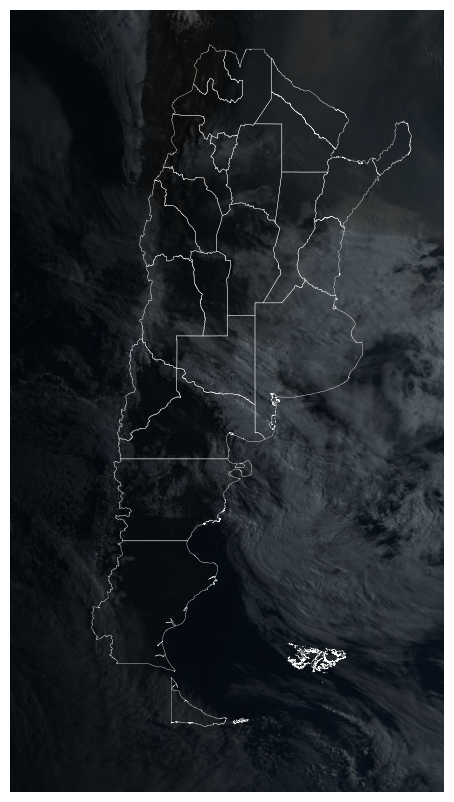

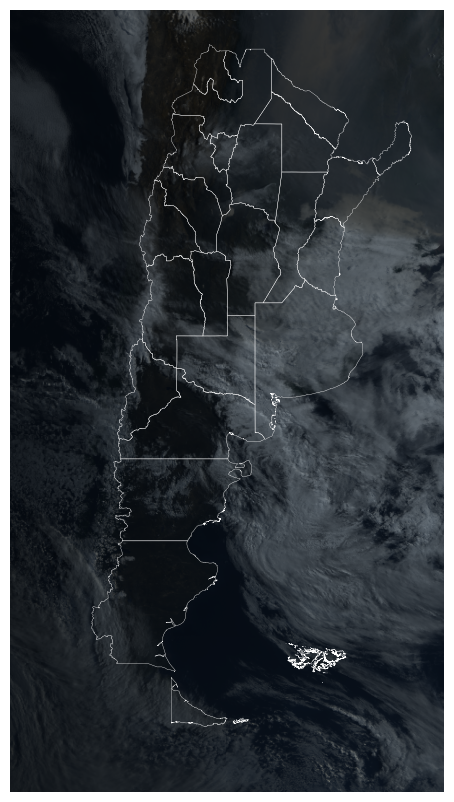

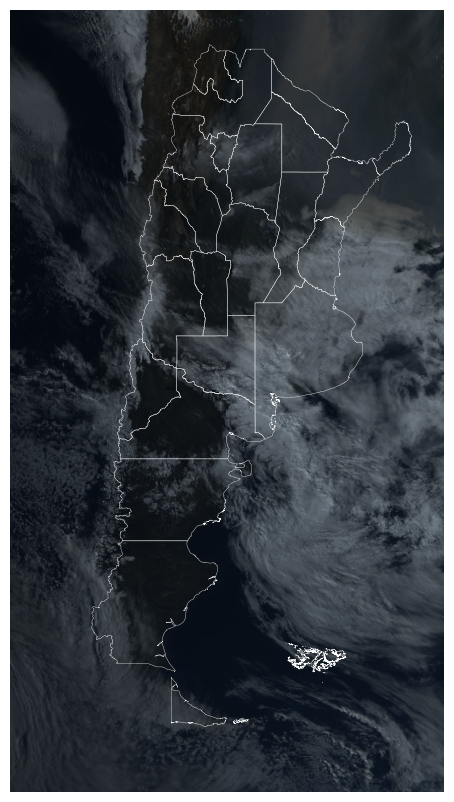

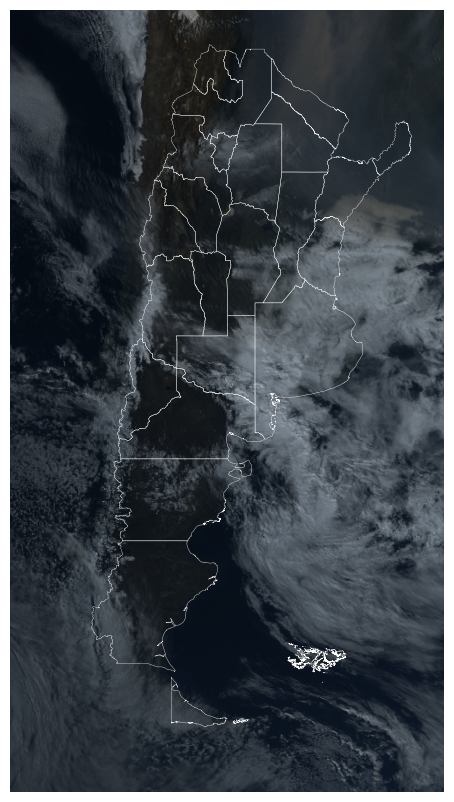

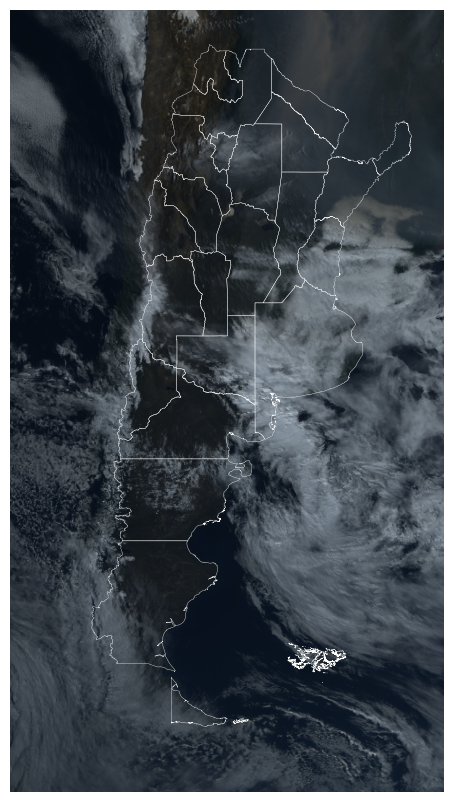

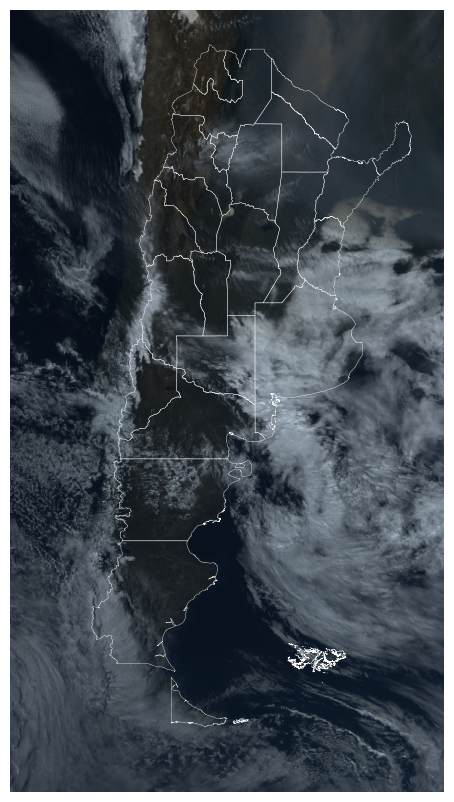

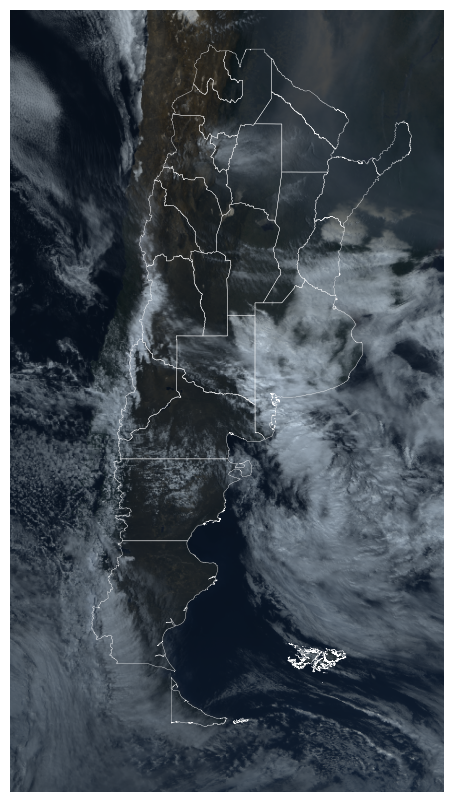

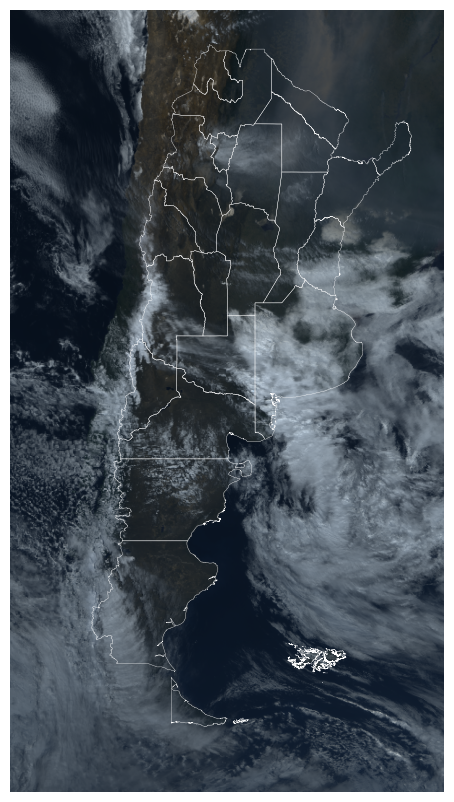

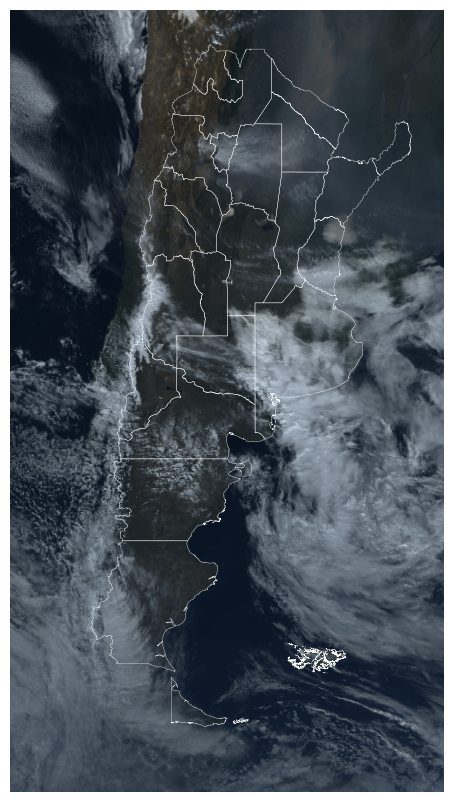

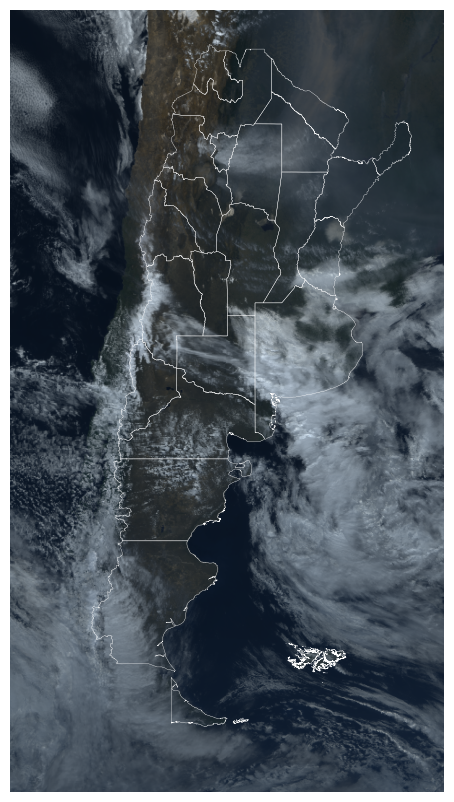

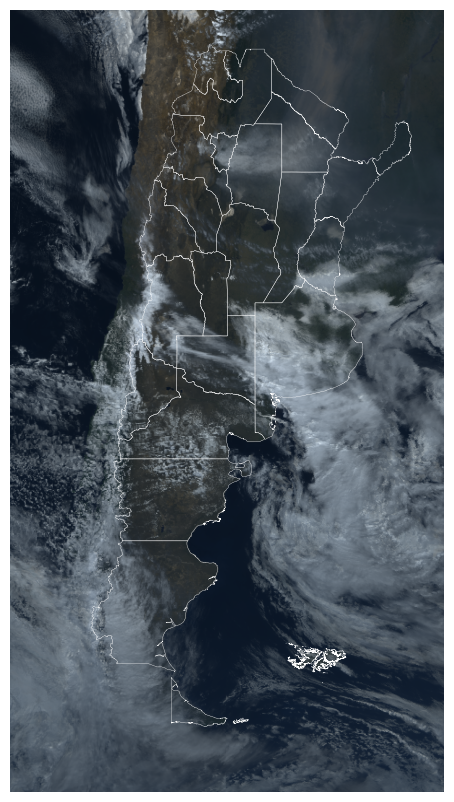

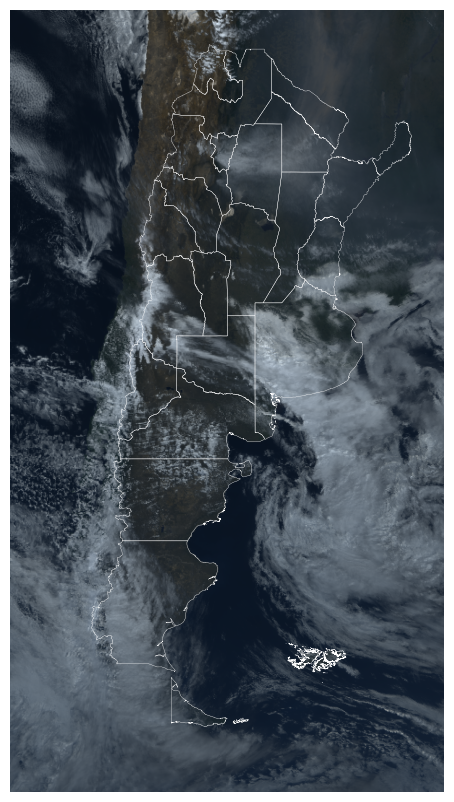

In [34]:
for t in range(S_02):
    
    fig, ax = plt.subplots(figsize=(5, 5*IR))

    for g, (k_2, B) in zip(range(len(GDF_GRD)), Bs.items()):

        RGB = np.stack([DICT_Rs_01[f"{g+1:02d}.G-{t+1:03d}.tif"].read(j) for j in range(1, 4)], axis=-1)
        
        _ = ax.imshow(RGB, extent=(B.left, B.right, B.bottom, B.top), zorder=1, vmin=0, vmax=0.7)

    ax.axis("off")

    GDF_PROVs.plot(ax=ax, facecolor="none", edgecolor="white", zorder=2, linewidth=.25)

    fig.tight_layout()
    plt.savefig(fr"Output/PNGs/T_{t+1:03d}.png")
    # plt.show();